In [203]:
import sys  
sys.path.insert(0, '../../Code')

import numpy as np
import os
import pandas as pd
import statistics
import train_and_predict
import util
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from Bio import SeqIO
from data import *
from sklearn.metrics import classification_report

In [235]:
LABEL = 'Label'

WSPC = 'WSPC'
BACPACS = 'BacPaCS'
PATHOGEN_FINDER = 'PathogenFinder'
PAPRBAG = 'PaPrBaG'

SEN = 'Sensitivity'
SPE = 'Specificity'
BACC = 'BAcc'

TARGET_NAMES = ['NHP', 'HP']

In [219]:
def report_to_metrics(report):
    
    specificity = round(report['NHP']['recall'], 2)
    sensitivity = round(report['HP']['recall'], 2)
    bacc = round(report['macro avg']['recall'], 2)

    
    return {SPE: specificity, SEN: sensitivity, BACC: bacc}

# Load Bacpacs Dataset

In [3]:
bacpacs_dir_path = r'..\..\Data\Bacpacs\\'

bacpacs_genomes_path = bacpacs_dir_path + 'bacpacs_genomes.fasta'
bacpacs_metadata_path = bacpacs_dir_path + 'bacpacs_test.csv'

In [4]:
bacpacs_dataset = GenomesData(bacpacs_genomes_path, bacpacs_metadata_path)

In [5]:
len(bacpacs_dataset)

94

## Balanced dataset (one genome per species)

In [7]:
balanced_dataset_genomes = bacpacs_dataset.metadata[bacpacs_dataset.metadata['Balanced Test'] == 'Yes'].index

In [8]:
bacpacs_data_balanced = bacpacs_dataset.data[balanced_dataset_genomes]

In [9]:
len(bacpacs_data_balanced)

40

# deepac model

In [20]:
deepac_on_bacpacs_dir_path = r'..\..\Data\Bacpacs\deepac_on_bacpacsTest\\'

In [21]:
# create  dictionary: key - genome name, value - dictionary(key:frag name, val: prediction)
def create_all_preds_per_genome(seqFile):
    
    all_p_per_genome_patho_test = {}
    for fasta in seqFile:
        name_and_p = fasta.description
        genome_name = name_and_p.split('pathogenic/')[1].split('.fq')[0]
        frag =  name_and_p.split('.fq.')[1].split(' | ')[0]
        all_p_per_genome_patho_test.setdefault(genome_name, {})
        all_p_per_genome_patho_test[genome_name][frag] = float(name_and_p.split('pp=')[1]) 

    print(f'results len: {len(all_p_per_genome_patho_test)}')          
    return all_p_per_genome_patho_test

In [22]:

"""
 "One of the major challenges of pathogenic potential prediction from single
reads is the lack of biological context. However, if all the reads in a sample
originate from the exactly same organism, we can predict the pathogenic
potential of that organism by a ---majority vote---. In the context of probabilistic
estimates of the class label (returned by both PaPrBaG and our neural
networks), we can implement that as a ---simple mean over predictions for
all the individual reads---. 
Building upon this idea, we can boost read-based performance if
we consider ***read pairs***, assumed to originate from the same organism
even in metagenomic samples. To this end, ---we average predictions for
the corresponding pairs in our test set---. The classifiers may still predict
pathogenic potentials for isolated sequences if so desired."
"""

def calculate_final_genomes_predictions(test_preds_1, test_preds_2):
    
    all_p_per_genome_test1 = create_all_preds_per_genome(test_preds_1)
    all_p_per_genome_test2 = create_all_preds_per_genome(test_preds_2)
    genomes_predictions = {}
    for genome in all_p_per_genome_test1.keys():
        all_frags1 = all_p_per_genome_test1[genome]
        all_frags2 = all_p_per_genome_test2[genome]
        if len((set(all_frags1) - set(all_frags2))) > 0:
            print('Error')
            return
        all_preds = []
        for frag_id in all_frags1.keys():
            y_pred_1 = all_frags1[frag_id]
            y_pred_2 = all_frags2[frag_id]
            y_pred = (y_pred_1 + y_pred_2)/2
            all_preds.append(y_pred)
            
        final_pred = statistics.mean(all_preds)
        genomes_predictions[genome] = final_pred
    
    return genomes_predictions

In [23]:
def get_deepac_predictions(test_genomes, test_labels, patho_genomes_predictions, nonpatho_genomes_predictions):
    deepac_preds_df = pd.DataFrame(index=test_genomes, columns=['Label', 'deepac_pred'])
    for genome_id in test_genomes:
        deepac_preds_df.at[genome_id, 'Label'] = int(test_labels.at[genome_id])
        if str(genome_id) in  patho_genomes_predictions.keys():
            deepac_preds_df.at[genome_id, 'deepac_pred'] = round(patho_genomes_predictions[genome_id])
            continue
        elif str(genome_id) in  nonpatho_genomes_predictions.keys():
            deepac_preds_df.at[genome_id, 'deepac_pred'] = round(nonpatho_genomes_predictions[genome_id])
            continue
        print(f'problem with genome: {genome_id}')

    return deepac_preds_df

## deepac s

In [28]:
patho_test_1_preds_s = SeqIO.parse(open(deepac_on_bacpacs_dir_path + 'patho_bacpacs_test1_withp_s.fasta'),'fasta')
patho_test_2_preds_s = SeqIO.parse(open(deepac_on_bacpacs_dir_path + 'patho_bacpacs_test2_withp_s.fasta'),'fasta')
patho_genomes_predictions_s = calculate_final_genomes_predictions(patho_test_1_preds_s, patho_test_2_preds_s)

results len: 0
results len: 0


In [26]:
nonpatho_test_1_preds_s = SeqIO.parse(open(deepac_on_bacpacs_dir_path + 'nonpatho_bacpacs_test1_withp_s.fasta'),'fasta')
nonpatho_test_2_preds_s = SeqIO.parse(open(deepac_on_bacpacs_dir_path + 'nonpatho_bacpacs_test2_withp_s.fasta'),'fasta')
nonpatho_genomes_predictions_s = calculate_final_genomes_predictions(nonpatho_test_1_preds_s, nonpatho_test_2_preds_s)

results len: 40
results len: 40


In [27]:
deepac_s_preds_df = get_deepac_predictions(bacpacs_dataset.metadata.index, labels,
                                                  patho_genomes_predictions_s, nonpatho_genomes_predictions_s)

#### Balanced test

In [28]:
deepac_s_balanced_preds_df = deepac_s_preds_df.loc[balanced_dataset_genomes]

In [29]:
print(classification_report(list(deepac_s_balanced_preds_df['Label']),
                            list(deepac_s_balanced_preds_df['deepac_pred']), target_names=TARGET_NAMES))

              precision    recall  f1-score   support

         NHP       1.00      0.33      0.50        15
          HP       0.71      1.00      0.83        25

    accuracy                           0.75        40
   macro avg       0.86      0.67      0.67        40
weighted avg       0.82      0.75      0.71        40



#### Entire test

In [30]:
print(classification_report(list(deepac_s_preds_df['Label']),
                            list(deepac_s_preds_df['deepac_pred']), target_names=TARGET_NAMES))

              precision    recall  f1-score   support

         NHP       0.83      0.31      0.45        16
          HP       0.88      0.99      0.93        78

    accuracy                           0.87        94
   macro avg       0.85      0.65      0.69        94
weighted avg       0.87      0.87      0.85        94



# DEEPAC R

In [31]:
patho_test_1_preds_r = SeqIO.parse(open(deepac_on_bacpacs_dir_path + 'patho_bacpacs_test1_withp.fasta'),'fasta')
patho_test_2_preds_r = SeqIO.parse(open(deepac_on_bacpacs_dir_path + 'patho_bacpacs_test2_withp.fasta'),'fasta')
patho_genomes_predictions_r = calculate_final_genomes_predictions(patho_test_1_preds_r, patho_test_2_preds_r)

results len: 60
results len: 60


In [32]:
nonpatho_test_1_preds_r = SeqIO.parse(open(deepac_on_bacpacs_dir_path + 'nonpatho_bacpacs_test1_withp.fasta'),'fasta')
nonpatho_test_2_preds_r = SeqIO.parse(open(deepac_on_bacpacs_dir_path + 'nonpatho_bacpacs_test2_withp.fasta'),'fasta')
nonpatho_genomes_predictions_r = calculate_final_genomes_predictions(nonpatho_test_1_preds_r, nonpatho_test_2_preds_r)

results len: 40
results len: 40


In [33]:
deepac_r_preds_df = get_deepac_predictions(bacpacs_dataset.metadata.index, labels,
                                                  patho_genomes_predictions_r, nonpatho_genomes_predictions_r)

#### Balanced test

In [34]:
deepac_r_balanced_preds_df = deepac_r_preds_df.loc[balanced_dataset_genomes]

In [35]:
print(classification_report(list(deepac_r_balanced_preds_df['Label']),
                            list(deepac_r_balanced_preds_df['deepac_pred']), target_names=TARGET_NAMES))

              precision    recall  f1-score   support

         NHP       1.00      0.33      0.50        15
          HP       0.71      1.00      0.83        25

    accuracy                           0.75        40
   macro avg       0.86      0.67      0.67        40
weighted avg       0.82      0.75      0.71        40



#### Entire test

In [36]:
print(classification_report(list(deepac_r_preds_df['Label']),
                            list(deepac_r_preds_df['deepac_pred']), target_names=TARGET_NAMES))

              precision    recall  f1-score   support

         NHP       0.83      0.31      0.45        16
          HP       0.88      0.99      0.93        78

    accuracy                           0.87        94
   macro avg       0.85      0.65      0.69        94
weighted avg       0.87      0.87      0.85        94



# Analyzing Paprbag, pathogenfinder and bacpacs results from bacpacs supplemantry

In [149]:
paprbag_folds =  ['paprbag_fold1', 'paprbag_fold2', 'paprbag_fold3', 'paprbag_fold4', 'paprbag_fold5']
bacpacs_methods = ['bacpacs', 'pathogenfinder'] + paprbag_folds

In [131]:
bacpacs_comp_analysis_sup = pd.read_csv(bacpacs_dir_path + 'Bacpacs-Supplementary.csv', dtype=str).set_index('Genome ID')
bacpacs_comp_analysis_sup = bacpacs_comp_analysis_sup.replace(['hp'], 1)
bacpacs_comp_analysis_sup = bacpacs_comp_analysis_sup.replace(['nhp'], 0)

In [132]:
bacpacs_comp_analysis_sup.head()

,pathogenicity,bacpacs,pathogenfinder,paprbag_fold1,paprbag_fold2,paprbag_fold3,paprbag_fold4,paprbag_fold5,Genome Name,Organism Name,Isolation Source,Habitat,Disease,Host Health,Other Clinical,Comments
Genome ID,,,,,,,,,,,,,,,,
1041522.28,1,1,1,1,1,1,1,1,Mycobacterium colombiense CECT 3035 strain CEC...,NaN,blood,NaN,NaN,HIV,NaN,M. colombiense infections were initially descr...
1196162.3,1,1,1,1,1,1,1,1,Listeria monocytogenes serotype 4b str. 10-080...,NaN,Stool,NaN,NaN,Listeriosis,NaN,Whole genome sequencing and comparison of List...
1196172.3,1,0,1,1,1,1,1,1,Listeria monocytogenes serotype 4b str. 02-128...,NaN,Stool,NaN,NaN,Listeriosis,NaN,Whole genome sequencing and comparison of List...
1280.11681,1,1,1,1,1,1,1,1,Staphylococcus aureus strain USA300-SUR15,NaN,Nose,NaN,NaN,NaN,NaN,The study characterizes a Staphylococcus aureu...
1280.12234,1,1,1,1,1,1,1,1,Staphylococcus aureus strain JE2,NaN,skin and soft tissue,NaN,NaN,Soft Tissue Infections,NaN,Sequence the genome of Staphylococcus aureus JE2


In [153]:
all_methods_preds = bacpacs_comp_analysis_sup.loc[bacpacs_dataset.y.index, bacpacs_methods]
all_methods_preds.loc[bacpacs_dataset.y.index, LABEL] = bacpacs_dataset.y

all_methods_preds.rename(columns={'bacpacs': BACPACS, 'pathogenfinder': PATHOGEN_FINDER}, inplace=True)

# WSPC model

In [159]:
model_path = '..\..\WSPC Model\WSPC_model.pkl'

WSPC_cls = util.load_model(model_path)

In [160]:
preds = WSPC_cls.predict(bacpacs_dataset.data) 
all_methods_preds.loc[bacpacs_dataset.y.index, WSPC] = preds

In [162]:
all_methods_preds

,BacPaCS,PathogenFinder,paprbag_fold1,paprbag_fold2,paprbag_fold3,paprbag_fold4,paprbag_fold5,Label,WSPC
Genome ID,,,,,,,,,
470.3353,1,1,1,1,1,1,1,1,1
106654.48,1,1,1,1,1,1,1,1,1
520.659,1,0,1,1,1,1,1,1,1
28450.385,1,1,1,1,1,1,1,1,1
83554.74,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
487.1548,1,1,0,0,1,0,1,1,0
287.3868,1,1,1,1,1,1,1,1,1
1280.12234,1,1,1,1,1,1,1,1,1


### Compute results for all classifiers

In [236]:
def get_cls_results(genomes, all_methods_preds, methods, measures):
    
    results = {}

    for method in methods:
        preds = all_methods_preds.loc[genomes, method]
        labels = all_methods_preds.loc[genomes, LABEL]
        report = classification_report(labels, preds, target_names=TARGET_NAMES, output_dict=True)
        method_results = report_to_metrics(report) 
        results[method] = method_results

    results[PAPRBAG] = {}
    for measure in measures:
        results[PAPRBAG][measure] = round(np.mean([results[fold][measure] for fold in paprbag_folds]), 2)

    return results

In [237]:
measures = [BACC, SEN, SPE]
methods = [WSPC, BACPACS, PATHOGEN_FINDER] + paprbag_folds
genomes = bacpacs_dataset.y.index

results_entire_test = get_cls_results(genomes, all_methods_preds, methods, measures)
results_entire_test

{'WSPC': {'Specificity': 0.88, 'Sensitivity': 0.99, 'BAcc': 0.93},
 'BacPaCS': {'Specificity': 0.75, 'Sensitivity': 0.92, 'BAcc': 0.84},
 'PathogenFinder': {'Specificity': 0.69, 'Sensitivity': 0.72, 'BAcc': 0.7},
 'paprbag_fold1': {'Specificity': 0.19, 'Sensitivity': 0.99, 'BAcc': 0.59},
 'paprbag_fold2': {'Specificity': 0.19, 'Sensitivity': 0.99, 'BAcc': 0.59},
 'paprbag_fold3': {'Specificity': 0.12, 'Sensitivity': 1.0, 'BAcc': 0.56},
 'paprbag_fold4': {'Specificity': 0.19, 'Sensitivity': 0.99, 'BAcc': 0.59},
 'paprbag_fold5': {'Specificity': 0.12, 'Sensitivity': 1.0, 'BAcc': 0.56},
 'PaPrBaG': {'BAcc': 0.58, 'Sensitivity': 0.99, 'Specificity': 0.16}}

In [238]:
results_balanced_test = get_cls_results(balanced_dataset_genomes, all_methods_preds, methods, measures)
results_balanced_test

{'WSPC': {'Specificity': 0.87, 'Sensitivity': 1.0, 'BAcc': 0.93},
 'BacPaCS': {'Specificity': 0.73, 'Sensitivity': 0.84, 'BAcc': 0.79},
 'PathogenFinder': {'Specificity': 0.67, 'Sensitivity': 0.96, 'BAcc': 0.81},
 'paprbag_fold1': {'Specificity': 0.2, 'Sensitivity': 1.0, 'BAcc': 0.6},
 'paprbag_fold2': {'Specificity': 0.2, 'Sensitivity': 1.0, 'BAcc': 0.6},
 'paprbag_fold3': {'Specificity': 0.13, 'Sensitivity': 1.0, 'BAcc': 0.57},
 'paprbag_fold4': {'Specificity': 0.2, 'Sensitivity': 1.0, 'BAcc': 0.6},
 'paprbag_fold5': {'Specificity': 0.13, 'Sensitivity': 1.0, 'BAcc': 0.57},
 'PaPrBaG': {'BAcc': 0.59, 'Sensitivity': 1.0, 'Specificity': 0.17}}

# Plots

In [231]:
def label_bars(rects, ax):
    for rect in rects:
        for label in rect:
            height = round(label.get_height(),2)
            ax.annotate('{}'.format(height), xy=(label.get_x() + label.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=14)

def create_comparative_barplots(results):
    
    methods = [WSPC, BACPACS, PATHOGEN_FINDER, PAPRBAG]
    measures = [BACC, SEN, SPE]

    width = 0.22
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    rects = []
    for i, method in enumerate(methods):
        vals = [round(results[method][measure], 2) for measure in measures]
        bar_positions = [x + i*width for x in np.arange(len(measures))]
        rect = ax.bar(bar_positions, vals, width, label=method)
        rects.append(rect)

    ax.set_ylabel('Scores',  fontsize=20)
    center_x =  width*len(measures)/2
    ax.set_xticks([x + center_x for x in np.arange(len(measures))]) 
    ax.set_xticklabels(measures, fontsize=20)
    ax.set_ylim([0.1, 1.05])
    #ax.legend(loc='lower right', bbox_to_anchor=(1.3, 0), prop=FontProperties().set_size('xx-large'))
    ax.legend(loc='lower right', bbox_to_anchor=(1, 0.85), prop=FontProperties().set_size('xx-large'))
    
    label_bars(rects, ax)
    
    fig.tight_layout()
    plt.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #plt.savefig('comparative_barplots_newTest_21.4.pdf')  
    plt.show()


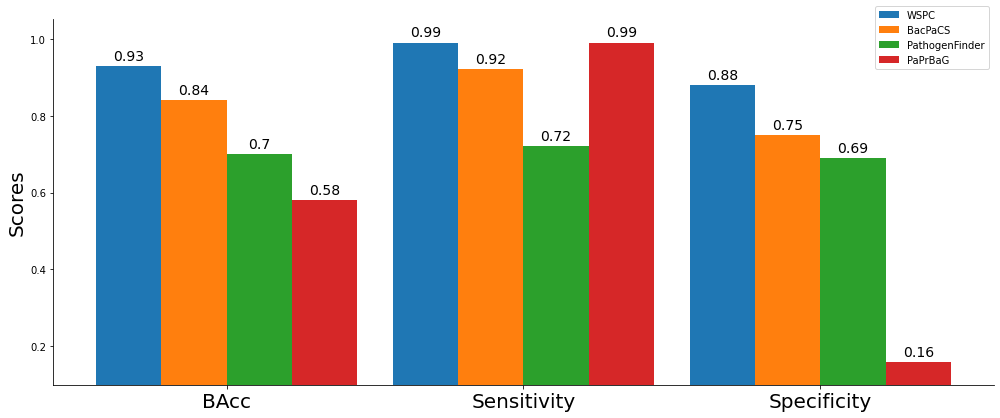

In [232]:
create_comparative_barplots(results_entire_test)

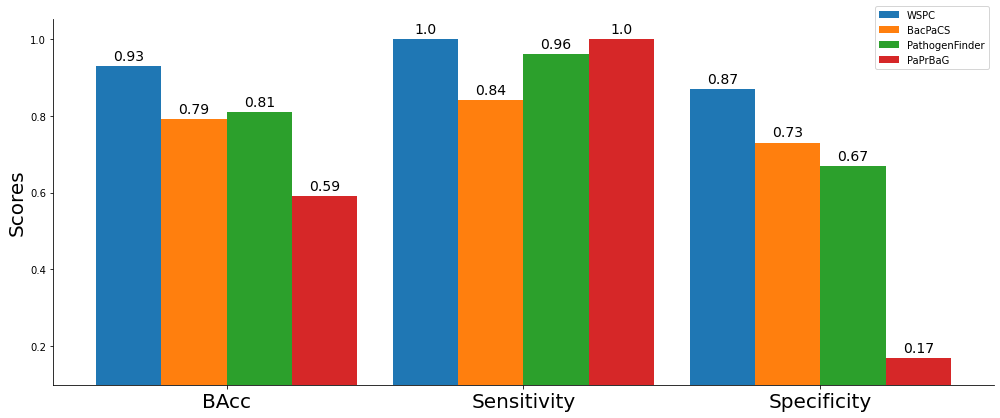

In [233]:
create_comparative_barplots(results_balanced_test)